In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importation des biliothèques et encodeurs

In [4]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout

from keras.layers import Bidirectional
from keras.layers import add

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence


#Téléchargement du dataset



Les documents sont fournis dans le code, il faut adapter les chemins




*   Token.txt : contiens les id des images et leurs 5 descriptions
*testImages.txt : contient les  id du training set 
*devImages.txt : contient les id du validation set 
*glove_path : Glove6D , qui va nous servir pour encoder le texte  

In [8]:
#à adapter

token_path = "Flickr8k.token.txt"
train_images_path = 'Flickr_8k.trainImages.txt'
test_images_path = 'Flickr_8k.testImages.txt'
val_images_path = 'Flickr_8k.devImages.txt'
images_path = 'Flicker8k_Dataset/'
glove_path = 'Flick8k_Text/'


doc = open(token_path,'r').read()
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


#Preprocessing des descriptions 

Création d'un dictionnaire : clé = nom de l'image, avec une liste de 5 descriptions annotées

In [9]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

On normalise les descriptions : retirer les pontuations et majuscucles

In [10]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

Illsutration avec un exemple :

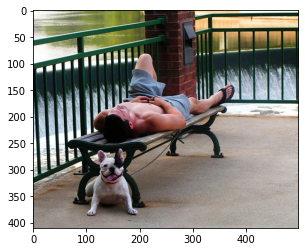

['a man lays on a bench while his dog sits by him ',
 'a man lays on the bench to which a white dog is also tied ',
 'a man sleeping on a bench outside with a white and black dog sitting next to him ',
 'a shirtless man lies on a park bench with his dog ',
 'man laying on bench holding leash of dog sitting on ground']

In [11]:
pic = '1003163366_44323f5815.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1003163366_44323f5815']

#Création du vocabulaire
Il y a en tout 40 000 descriptions dans notre base de données. Nous allons créer un vocabulaire contenant l'ensemble des mots (en retirant les doublons), pour en faire un vocabulaire avec des mots uniques

In [12]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Taille du vocabulaire unique: %d' % len(vocabulary))

Taille du vocabulaire unique: 8828


In [13]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)


Pour le train set

In [14]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)
print(len(train))

6000


Pour le validation set 

In [15]:
doc_val = open(val_images_path,'r').read()
dataset_val = list()
for line in doc_val.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset_val.append(identifier)

val_set = set(dataset_val)
print(len(val_set))

1000


Pour le test

In [16]:
doc_test = open(test_images_path,'r').read()
dataset_test= list()
for line in doc_test.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset_test.append(identifier)

test_set = set(dataset_test)
print(len(test_set))

1000


Pour le test set 

In [17]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

val_images = set(open(val_images_path, 'r').read().strip().split('\n'))
val_img = []
for i in img: 
    if i[len(images_path):] in val_images:
        val_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)

Création des dictionnaires respectifs
--> on rajoute 2 token à chq description : _endseq_ et _stratseq_

Pour le train set : 

In [18]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

Pour le val set 

In [19]:
val_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in val_set:
        if image_id not in val_descriptions:
            val_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        val_descriptions[image_id].append(desc)

In [20]:
test_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in test_set:
        if image_id not in test_descriptions:
            test_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        test_descriptions[image_id].append(desc)
        

In [21]:
test_captions = []
for key, val in test_descriptions.items():
    for cap in val:
       test_captions.append(cap)

In [22]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

Rmq : on peut varier le nb de répetitions , mais 10   donne les meilleurs résutltats

In [23]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1659


Création de deux dictionnaires pour mapper les mots dans un index. Des 0 sont rajoutées pour rendre nos descriptions de même longueur

In [25]:
ixtoword = {}
wordtoix = {}
ix = 1 # l'index commence à 1 et non  0
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1
print(vocab_size)

1660


La taille de notre nouveau vocabulaire est de 1660 mots.

Trouver la longueur max d'une descriptions car on ne peut pas avoir des descriptions de taille arbitraire lorsqu'on va les générer

In [28]:
all_desc = list()
for key in val_descriptions.keys():
    [all_desc.append(d) for d in val_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Taille max description : %d' % max_length)

Taille max description : 35


#Importation de l'encodeur texte : Glove 
Ici nous allons utiliser un vecteur de 200 dimensions

Nous avons également encodé les captions. Nous avons utilisé GloVe, Gloval Vectors for Word Reprentation. Il fut initialement présenté en 2015, dans l'article originel "GloVe: Global Vectors for Word Representation" de Jeffrey Pennington, R. Socher et Christopher D. Manning, chercheurs à l'Université de Stanford à cette époque.

Les vecteurs de mots correspondent aux mots dans un espace vectoriel, où les mots similaires sont regroupés et les mots différents sont séparés. L'avantage d'utiliser Glove par rapport à Word2Vec est que GloVe ne se contente pas de s'appuyer sur le contexte local des mots, mais intègre la cooccurrence globale des mots pour obtenir des vecteurs de mots. En effet les informations de co-occurrence peuvent fournir des informations supplémentaires sur les relations sémantiques et syntaxiques entre les mots,ce qui peut améliorer les performances des modèles qui utilisent ces vecteurs.
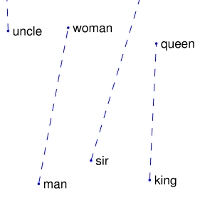

On peut retrouver des relations sémantqiues entre les mots dans la matrice de co occurence.

Nous mappons la caption de longuuer max dans un vecteur a 200 dimension

In [29]:
embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [35]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(embedding_vector.shape)
print(embedding_matrix.shape)

(200,)
(1660, 200)


Nous obtenons également une matrice (1660, 220) qui correspond à notre vocabulaire et le vecteur à 200-d

#Importation de l'encodeur image : Inception V3 

Inception v3 est un modèle de reconnaissance d'image qui a atteint une précision supérieure à 78,1% sur l'ensemble de données ImageNet. Ce modèle est l'aboutissement de nombreuses idées développées par plusieurs chercheurs au fil des ans. Il est basé sur l'article originel Rethinking the Inception Architecture for Computer Vision (Repenser l'architecture Inception pour la vision par ordinateur) de Szegedy, et. al.

Le modèle lui-même est composé de composants symétriques et asymétriques, dont les convolutions, le average pooling , le max pooling, les concaténations, les abandons et les couches entièrement connectées. La normalisation des lots est utilisée de manière approfondie dans le modèle et appliquée aux entrées d'activation. La perte est calculée à l'aide de Softmax.

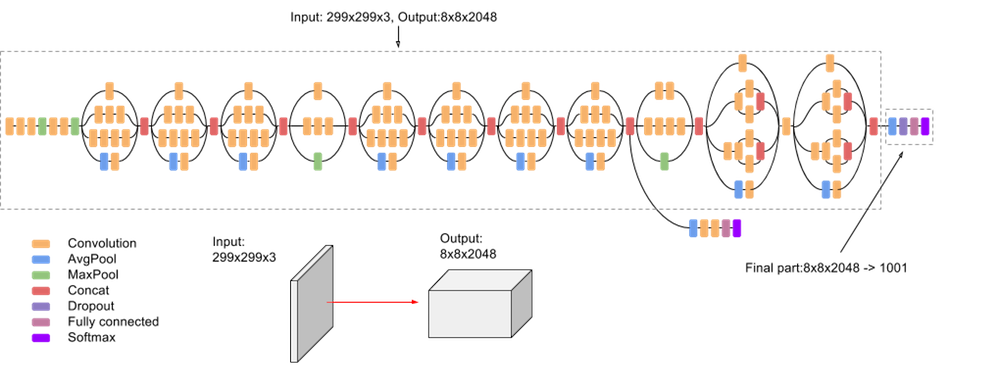

In [ ]:
model = InceptionV3(weights='imagenet')

96112376/96112376 [==============================] - 5s 0us/step


Le softmax layer est retiré car nous n'avons pas besoin de classifier les images. On extraie l'image sous la forme d'un vecteur

In [ ]:
model_new = Model(model.input, model.layers[-2].output)

##Preprocessing des images

Remarque : cette étape d'extraction de features prend beaucoup de temps, nous l'avons réalisé une seule fois. Les fichiers : test_features.pkl , train_features.pkl et val_features.pkl contiennent les features, il suffira de les ouvrir et de remettre le dictionnaire dans une nouvelle variable dictionnaire. Si vous souhaitez modifier les elements du vocabulaire , il faudra encoder de nouveau l'ensemble des 8000 images que nous avons (1h d'éxecution)

On normalise les images en 299 x 299 , comme exigé par le modèle

In [36]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [ ]:
import keras.utils as image

Extraction des vecteurs des images, taille du format :  (1,2048). On encode les set rescpectifs : train, val et test
C'est une étape chronophage également 

In [ ]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

train_set : 

In [ ]:
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
    
train_features = encoding_train

val_set

In [ ]:
encoding_val = {}
for img in val_img:
    encoding_val[img[len(images_path):]] = encode(img)
val_features = encoding_val

test_set

In [ ]:
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)


In [ ]:
test_features = encoding_test
print(type(test_features))

<class 'dict'>


Enregristrement des images encodées dans un fichier 

In [37]:
import pickle

In [ ]:
#chemins des fichiers où nous allons enregistrer les features
train_features_path =""
val_features_path =""
test_features_path =""

# Le dictionnaire à enregistrer
"""

# Ouvrir le fichier en mode écriture binaire
with open(train_features_path, 'wb') as f:
    # Enregistrer les données en utilisant pickle.dump()
    pickle.dump(train_features, f)

# Ouvrir le fichier en mode écriture binaire
with open(val_features_path, 'wb') as f:
    # Enregistrer les données en utilisant pickle.dump()
    pickle.dump(val_features, f)

# Ouvrir le fichier en mode écriture binaire
with open(test_features_path, 'wb') as f:
    # Enregistrer les données en utilisant pickle.dump()
    pickle.dump(test_features, f)"""

"\n\n# Ouvrir le fichier en mode écriture binaire\nwith open('/content/drive/MyDrive/Colab_Notebooks/Projet_modele_vision/Projet_Vision/code/flickr/features/train_features.pkl', 'wb') as f:\n    # Enregistrer les données en utilisant pickle.dump()\n    pickle.dump(train_features, f)\n\n# Ouvrir le fichier en mode écriture binaire\nwith open('/content/drive/MyDrive/Colab_Notebooks/Projet_modele_vision/Projet_Vision/code/flickr/features/val_features.pkl', 'wb') as f:\n    # Enregistrer les données en utilisant pickle.dump()\n    pickle.dump(val_features, f)\n\n# Ouvrir le fichier en mode écriture binaire\nwith open('/content/drive/MyDrive/Colab_Notebooks/Projet_modele_vision/Projet_Vision/code/flickr/features/test_features.pkl', 'wb') as f:\n    # Enregistrer les données en utilisant pickle.dump()\n    pickle.dump(test_features, f)"

In [ ]:

# Ouvrir le fichier en mode lecture binaire
with open(train_features_path, 'rb') as f:
    # Charger les données en utilisant pickle.load()
    train_features = pickle.load(f)




# Ouvrir le fichier en mode lecture binaire
with open(val_features_path, 'rb') as f:
    # Charger les données en utilisant pickle.load()
    val_features = pickle.load(f)




# Ouvrir le fichier en mode lecture binaire
with open(test_features_path, 'rb') as f:
    # Charger les données en utilisant pickle.load()
    test_features = pickle.load(f)


print(type(test_features))

<class 'dict'>


#Elaboration du modèle

In [38]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 200)      332000      ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_1[0][0]']                
                                                                                              



*   Input2 : features vecteur extraite par Inceptionv3. Un dropout de 0.5 est rajouté pour éviter l'overfitting
*   Input3  : les mots sont encoder dans l'encodeur 200-d de Glove. 
*LSTM : Le input passe dans le LSTM pour le traitement des séquences.

Les deux encodeurs sont concaténés et introduit dans une FC layer cette couche softmax donne la probabilité au vocabulaire de 1660 mots.



##Entrainement du modèle

On précise qu'on n'entraine pas de nouveau les poids 

In [39]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

On entraine les données sous forme de batch

In [40]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    #on boucle les images 
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # on retourne les feature de l'image
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # la description est encodée
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                
                for i in range(1, len(seq)):                  
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad la séquence en entrée
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode la sequence en sortie
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

train et validation generator 

In [41]:
#mettre le chemin pour enregistrer les modèles qu'on a entrainé
modele_path =""
def train_models(epoch_size, batch, generator, val_generator, train_features, val_features, max_length):
  epochs = epoch_size
  batch_size = batch
  steps = len(train_descriptions)//batch_size
  steps_val = len(val_descriptions)//batch_size
  generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
  val_generator = data_generator(val_descriptions, val_features, wordtoix, max_length, batch_size)
  model.compile(loss='mse',optimizer='Adam', metrics=['accuracy'])
  train_history= model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1, validation_data = val_generator, validation_steps = steps_val)
  #pour la loss
  train_loss = train_history.history['loss']
  val_loss = train_history.history['val_loss']
  plt.title('model loss')
  plt.plot(train_loss)
  plt.plot(val_loss)
  plt.legend(['train_loss', 'val_loss'])
  plt.show()
  #pour l'accuracy
  plt.plot(train_history.history['accuracy'])
  plt.plot(train_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()
  file_name= 'model_nb_epoch_{'
  model.save(modele_path + file_name+str(epochs)+'}.h5')
  return train_history


##Entrainement et enregistrement des modèles

Pour 5 epoch

In [42]:
#epochs = 5
batch_size = 3
steps = len(train_descriptions)//batch_size
steps_val = len(val_descriptions)//batch_size

In [ ]:
generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
val_generator = data_generator(val_descriptions, val_features, wordtoix, max_length, batch_size)

Epoch 1/5
2000/2000 [==============================] - 159s 78ms/step - loss: 5.4628e-04 - accuracy: 0.2230 - val_loss: 5.1214e-04 - val_accuracy: 0.2905
Epoch 2/5
2000/2000 [==============================] - 155s 78ms/step - loss: 5.0582e-04 - accuracy: 0.3047 - val_loss: 4.9409e-04 - val_accuracy: 0.3245
Epoch 3/5
2000/2000 [==============================] - 154s 77ms/step - loss: 4.9221e-04 - accuracy: 0.3301 - val_loss: 4.8544e-04 - val_accuracy: 0.3432
Epoch 4/5
2000/2000 [==============================] - 152s 76ms/step - loss: 4.8325e-04 - accuracy: 0.3457 - val_loss: 4.8160e-04 - val_accuracy: 0.3518
Epoch 5/5
2000/2000 [==============================] - 154s 77ms/step - loss: 4.7711e-04 - accuracy: 0.3566 - val_loss: 4.7780e-04 - val_accuracy: 0.3586


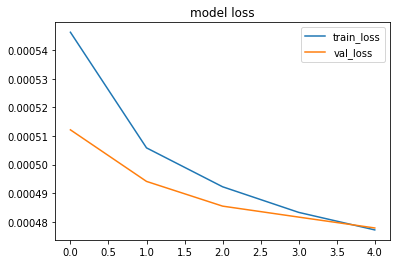

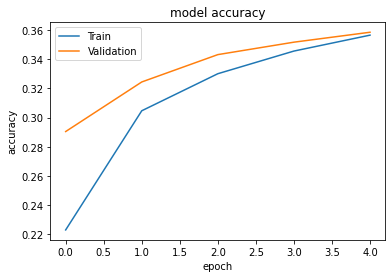

In [ ]:
train_history= train_models(5,batch_size, generator, val_generator, train_features,val_features,max_length)


Pour 10 epoch

Epoch 1/10
2000/2000 [==============================] - 159s 78ms/step - loss: 4.7209e-04 - accuracy: 0.3656 - val_loss: 4.7510e-04 - val_accuracy: 0.3638
Epoch 2/10
2000/2000 [==============================] - 155s 77ms/step - loss: 4.6907e-04 - accuracy: 0.3720 - val_loss: 4.7149e-04 - val_accuracy: 0.3718
Epoch 3/10
2000/2000 [==============================] - 154s 77ms/step - loss: 4.6554e-04 - accuracy: 0.3780 - val_loss: 4.6917e-04 - val_accuracy: 0.3749
Epoch 4/10
2000/2000 [==============================] - 155s 77ms/step - loss: 4.6275e-04 - accuracy: 0.3826 - val_loss: 4.6817e-04 - val_accuracy: 0.3749
Epoch 5/10
2000/2000 [==============================] - 155s 78ms/step - loss: 4.5985e-04 - accuracy: 0.3879 - val_loss: 4.6725e-04 - val_accuracy: 0.3780
Epoch 6/10
2000/2000 [==============================] - 155s 78ms/step - loss: 4.5751e-04 - accuracy: 0.3921 - val_loss: 4.6559e-04 - val_accuracy: 0.3815
Epoch 7/10
2000/2000 [==============================] - 155s 78ms/step

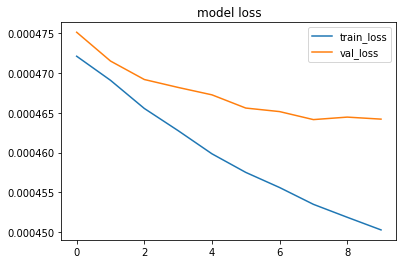

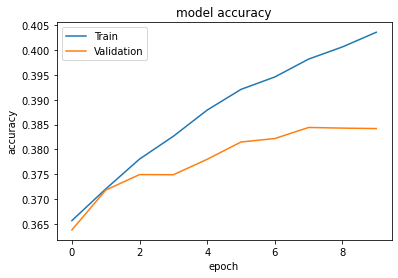

In [ ]:
train_models(10,batch_size, generator, val_generator, train_features,val_features,max_length)


Pour 20 epoch

Epoch 1/20
2000/2000 [==============================] - 159s 78ms/step - loss: 4.4671e-04 - accuracy: 0.4092 - val_loss: 4.6480e-04 - val_accuracy: 0.3847
Epoch 2/20
2000/2000 [==============================] - 155s 77ms/step - loss: 4.4599e-04 - accuracy: 0.4109 - val_loss: 4.6374e-04 - val_accuracy: 0.3881
Epoch 3/20
2000/2000 [==============================] - 156s 78ms/step - loss: 4.4509e-04 - accuracy: 0.4120 - val_loss: 4.6456e-04 - val_accuracy: 0.3847
Epoch 4/20
2000/2000 [==============================] - 156s 78ms/step - loss: 4.4356e-04 - accuracy: 0.4139 - val_loss: 4.6403e-04 - val_accuracy: 0.3855
Epoch 5/20
2000/2000 [==============================] - 156s 78ms/step - loss: 4.4242e-04 - accuracy: 0.4159 - val_loss: 4.6458e-04 - val_accuracy: 0.3855
Epoch 6/20
2000/2000 [==============================] - 156s 78ms/step - loss: 4.4116e-04 - accuracy: 0.4183 - val_loss: 4.6541e-04 - val_accuracy: 0.3855
Epoch 7/20
2000/2000 [==============================] - 155s 78ms/step

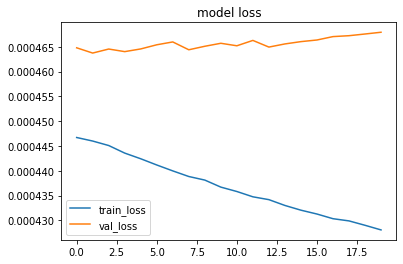

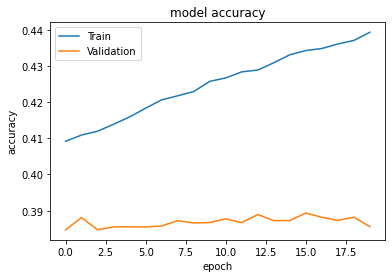

In [ ]:
train_models(20,batch_size, generator, val_generator, train_features,val_features,max_length)

Epoch 1/30
2000/2000 [==============================] - 156s 76ms/step - loss: 4.2632e-04 - accuracy: 0.4417 - val_loss: 4.6786e-04 - val_accuracy: 0.3862
Epoch 2/30
2000/2000 [==============================] - 153s 76ms/step - loss: 4.2652e-04 - accuracy: 0.4414 - val_loss: 4.6761e-04 - val_accuracy: 0.3864
Epoch 3/30
2000/2000 [==============================] - 153s 76ms/step - loss: 4.2599e-04 - accuracy: 0.4419 - val_loss: 4.6807e-04 - val_accuracy: 0.3865
Epoch 4/30
2000/2000 [==============================] - 154s 77ms/step - loss: 4.2508e-04 - accuracy: 0.4432 - val_loss: 4.6916e-04 - val_accuracy: 0.3873
Epoch 5/30
2000/2000 [==============================] - 153s 77ms/step - loss: 4.2451e-04 - accuracy: 0.4443 - val_loss: 4.6793e-04 - val_accuracy: 0.3865
Epoch 6/30
2000/2000 [==============================] - 154s 77ms/step - loss: 4.2371e-04 - accuracy: 0.4455 - val_loss: 4.6879e-04 - val_accuracy: 0.3854
Epoch 7/30
2000/2000 [==============================] - 154s 77ms/step

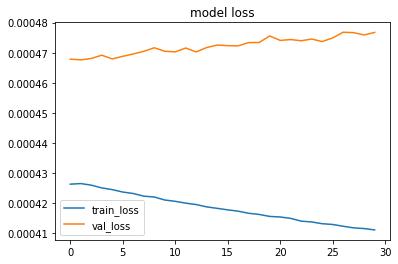

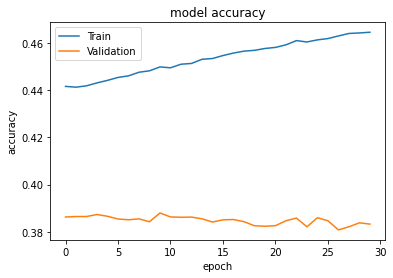

In [ ]:
train_models(30,batch_size, generator, val_generator, train_features,val_features,max_length)

Détermination du modèle final : on s'arrête apres 7 epoch

Epoch 1/7
2000/2000 [==============================] - 170s 83ms/step - loss: 4.9251e-04 - accuracy: 0.3293 - val_loss: 4.8780e-04 - val_accuracy: 0.3372
Epoch 2/7
2000/2000 [==============================] - 165s 83ms/step - loss: 4.8524e-04 - accuracy: 0.3426 - val_loss: 4.8263e-04 - val_accuracy: 0.3478
Epoch 3/7
2000/2000 [==============================] - 166s 83ms/step - loss: 4.7856e-04 - accuracy: 0.3551 - val_loss: 4.7721e-04 - val_accuracy: 0.3594
Epoch 4/7
2000/2000 [==============================] - 165s 82ms/step - loss: 4.7325e-04 - accuracy: 0.3640 - val_loss: 4.7414e-04 - val_accuracy: 0.3642
Epoch 5/7
2000/2000 [==============================] - 164s 82ms/step - loss: 4.6880e-04 - accuracy: 0.3721 - val_loss: 4.7187e-04 - val_accuracy: 0.3706
Epoch 6/7
2000/2000 [==============================] - 166s 83ms/step - loss: 4.6520e-04 - accuracy: 0.3787 - val_loss: 4.6966e-04 - val_accuracy: 0.3731
Epoch 7/7
2000/2000 [==============================] - 165s 83ms/step - loss

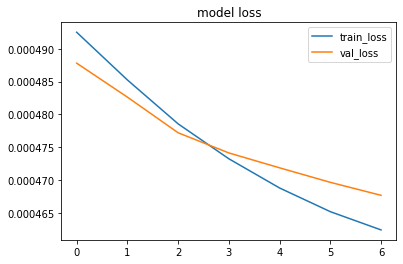

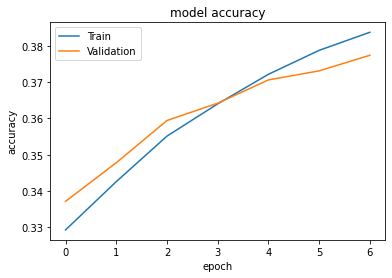

In [ ]:
model = train_models(7,batch_size, generator, val_generator, train_features,val_features,max_length)

#Evaluation : Comparaison entre greedy search et beam search 

Pour générer nos captions nous avons utilisé deux approches différentes : Greedy Search (recherche gloutonne en français) et Beam Search (recherche par balayage)

In [ ]:
encoding_test_=test_features

In [ ]:
print(test_features)

##Greedy Search 

Greedy Search : méthode qui consiste à choisir à chaque étape la meilleure option disponible, en se basant sur la probabilité de chaque mot généré par le modèle

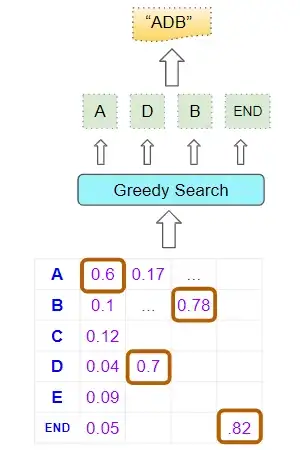




In [ ]:
def greedySearch(photo, model):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

##Beam Search

Beam Search : méthode plus avancée qui consiste à conserver un certain nombre de meilleures options (appelées "faisceaux") à chaque étape, plutôt qu'une seule. A chaque étape, le modèle calcule la probabilité de chaque mot pour chaque faisceau, puis en conserve un certain nombre pour la prochaine étape.

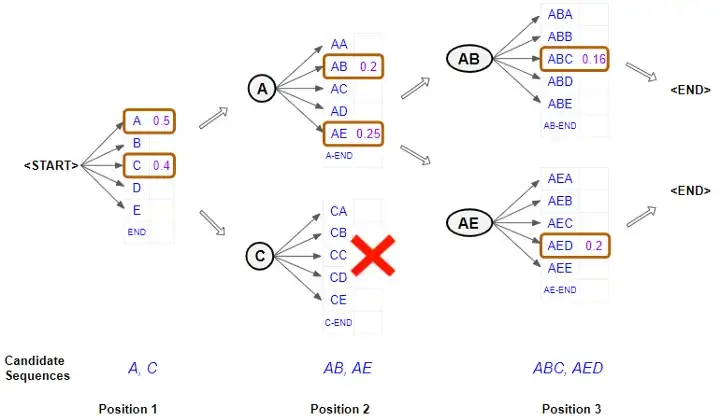

In [ ]:
def beam_search_predictions(model, image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

## Calcul des métriques : Bleu score

Notre tache consiste à générer des données, donc les métriques classiques telles que la précision ou le rappel ne seront pas d'une grande utilité. Nous allons utiliser la métrique BLEU Score (bilingual evaluation understudy).
Le BLEU score (ou coefficient de BLEU) est un indicateur de performance couramment utilisé pour évaluer la qualité des modèles de génération de langage, ceci est cas dans notre projet. Le score BLEU mesure la similitude entre une phrase générée par le modèle et une phrase de référence (généralement appelée "phrase cible").

Le BLEU score calcule la proportion de n-grammes (séquences de mots de longueur n) qui apparaissent dans la phrase générée et dans la phrase de référence. Plus cette proportion est élevée, plus la phrase générée est similaire à la phrase de référence, et plus le BLEU score est élevé.

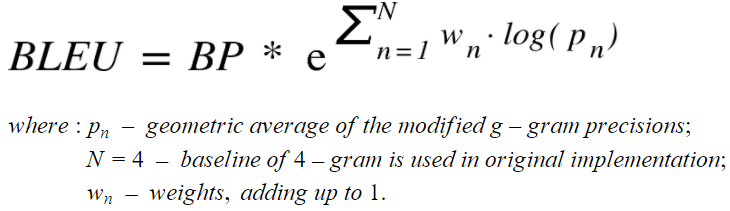

##Evaluation quantitative

In [ ]:
encoding_test_ = test_features


###Calcul des métriques avec ***Greedy Search*** ; Bleu score 

---



Affichage que de quelques exemples : 

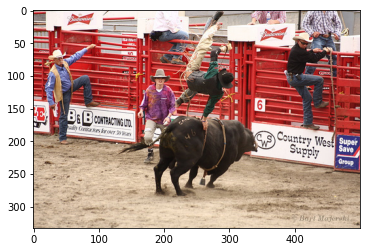

Referance Captions: 
startseq a man is roping a bull in a rodeo while others in cowboy hats watch endseq
startseq a man is up in the air with one hand on a bull endseq
startseq a rodeo rider gets tossed up into the air by a black bull as fellow cowboys look on endseq
startseq man getting thrown in the air while bull riding endseq
startseq the man in black is flying off the full in front of a red fence endseq
Predicted Caption: 
a man in a white shirt is standing in front of a man in a black shirt
bleu score:  0.6495852436964357


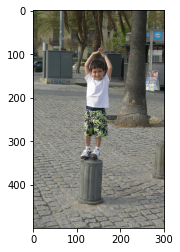

Referance Captions: 
startseq a boy with his hands above his head stands on a cement pillar above the cobblestones endseq
startseq a child in colorful shorts is standing on a post in the street endseq
startseq a small boy stands on a cement stump in a park with his hands on his head endseq
startseq a young man wearing a white tshirt and green and black shorts standing on a stump endseq
startseq small child in white shirt and print shorts with hands over their head standing on object endseq
Predicted Caption: 
a man in a white shirt and a woman in a white shirt and a woman in a white shirt and a woman in a white shirt and a woman in a white shirt
bleu score:  0.33265140961867357


In [ ]:

i=0

for img_id in test_features:
  
  i+=1
  img=cv2.imread(images_path+ "/" + img_id)
  
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  photo = photo.reshape((1,2048))
  plt.show()
  reference=[]
  img_id = img_id.replace('.jpg','')
  for caps in test_descriptions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(caps)
  candidate=greedySearch(photo,model)
  score = sentence_bleu(reference, candidate)



  print("Referance Captions: ")
  for cap in reference:
    print(cap)
  print("Predicted Caption: ")
  print(candidate)
  print("bleu score: ",score)
 
  if(i==2):
    break

moyenne greedy search bleu score 

In [ ]:
i=0
tot_score = 0
for img_id in test_features:
  
  i+=1
  img=cv2.imread(images_path+ "/" + img_id)
  
  #plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  photo = photo.reshape((1,2048))
  #plt.show()
  reference=[]
  img_id = img_id.replace('.jpg','')
  for caps in test_descriptions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(caps)
  candidate=greedySearch(photo,model)
  score = sentence_bleu(reference, candidate)
  tot_score+=score
avg_score=tot_score/i


print()
print("Bleu score on Greedy search")
print("Score: ",avg_score)


Bleu score on Greedy search
Score:  0.4841700311840232


###Calcul des métriques avec ***Beam Search*** ; Bleu score 

----


Quelques exemples sur des images 

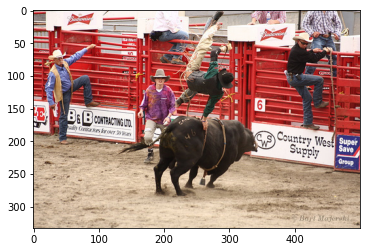

Referance Captions: 
startseq a man is roping a bull in a rodeo while others in cowboy hats watch endseq
startseq a man is up in the air with one hand on a bull endseq
startseq a rodeo rider gets tossed up into the air by a black bull as fellow cowboys look on endseq
startseq man getting thrown in the air while bull riding endseq
startseq the man in black is flying off the full in front of a red fence endseq
Predicted Caption: 
a group of people are sitting on a bench with a stick in his mouth
bleu score with beam search k = 3:  0.511649447573598
Predicted Caption: 
a black and white dog with a stick in its mouth
bleu score with beam search k = 7:  0.3976144530125924
Predicted Caption: 
a black and white dog with a ball in its mouth
bleu score with beam search k = 10:  0.41339402968770395


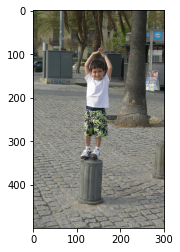

Referance Captions: 
startseq a boy with his hands above his head stands on a cement pillar above the cobblestones endseq
startseq a child in colorful shorts is standing on a post in the street endseq
startseq a small boy stands on a cement stump in a park with his hands on his head endseq
startseq a young man wearing a white tshirt and green and black shorts standing on a stump endseq
startseq small child in white shirt and print shorts with hands over their head standing on object endseq
Predicted Caption: 
a man in a black shirt is sitting on a bench near a city street
bleu score with beam search k = 3:  0.5766713384405441
Predicted Caption: 
a little girl in a red shirt is sitting on a sidewalk
bleu score with beam search k = 7:  0.3428410186098844
Predicted Caption: 
a group of people are sitting on a city street in front of a city street
bleu score with beam search k = 10:  0.4160250392706112


In [ ]:
i=0
tot_score = 0
for img_id in test_features:
  
  i+=1
  img=cv2.imread(images_path+ "/" + img_id)
  
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  photo = photo.reshape((1,2048))
  plt.show()
  reference=[]
  img_id = img_id.replace('.jpg','')
  for caps in test_descriptions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(caps)
  candidate_BS_3=beam_search_predictions(model,photo,3)
  candidate_BS_7=beam_search_predictions(model,photo,7)
  candidate_BS_10=beam_search_predictions(model,photo,10)
  score_k3 = sentence_bleu(reference, candidate_BS_3)
  score_k7 = sentence_bleu(reference, candidate_BS_7)
  score_k10 = sentence_bleu(reference, candidate_BS_10)

  print("Referance Captions: ")
  for cap in reference:
    print(cap)
  print("Predicted Caption: ")
  print(candidate_BS_3)
  print("bleu score with beam search k = 3: ",score_k3)
  print("Predicted Caption: ")
  print(candidate_BS_7)
  print("bleu score with beam search k = 7: ",score_k7)
  print("Predicted Caption: ")
  print(candidate_BS_10)
  print("bleu score with beam search k = 10: ",score_k10)
  if(i==2):
    break

Moyenne beam search k=3 

In [ ]:
i=0
tot_score_k3 = 0


for img_id in test_features:
  
  i+=1
  img=cv2.imread(images_path+ "/" + img_id)
  

  photo=test_features[img_id]
  photo = photo.reshape((1,2048))
  
  reference=[]
  img_id = img_id.replace('.jpg','')
  for caps in test_descriptions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(caps)
  candidate_BS_3=beam_search_predictions(model,photo,3)

  score_k3 = sentence_bleu(reference, candidate_BS_3)

  tot_score_k3+=score_k3


avg_score_k3 =tot_score_k3/i

print()
print("Moyenne score bleu pour : \n")
print("k = 3 :", avg_score_k3)


/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)



Moyenne score bleu pour : 

k = 3 : 0.521337623403011


#Evaluation qualitative 

L'évaluation qualitative obejctive de cette tâche est difficile , et ce pour plusieurs raisons . En effet il y a une forte subjectivité car les descriptions peuvent être interprétées de différentes manières. Toutefois, nous pouvons tout de même afficher certaines images et demander à une personne de l'interpréter : ceci est l'évaluations humaine. Prenons le cas de cette image, qui nous montre les prédictions du modèles avec les deux approches que avons étudié:

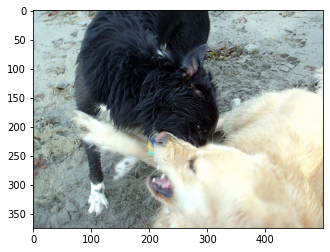

Greedy Search: a black dog is jumping up to catch a frisbee
Beam Search, K = 3: a black dog and a black dog play with a red ball in the grass
Beam Search, K = 5: a black dog and a black dog play with a red ball in the grass
Beam Search, K = 7: a black and white dog is playing with a red ball in the grass
Beam Search, K = 10: a black and white dog playing with a red ball in the grass


In [ ]:

pic = '1897025969_0c41688fa6.jpg'
image = encoding_test_[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image,model))
print("Beam Search, K = 3:",beam_search_predictions(model,image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(model,image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(model, image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(model, image, beam_index = 10))

Concernant cette image, si une personne devait la décrire en une phrase courte, elle peut la décrire de la façon suivante "Un chien noir mord la patte d'un autre chien", ou une autre personnes peut dire "Deux chiens jouent ensemble, l'un mord la patte de l'autre". Les deux descriptions sont pertinentes. 
Il est également possible d'utiliser d'autres types d'évualuations :


* *L'évaluation par sondage *texte en italique*: Les évaluations par sondage consistent à faire juger les descriptions générées par un modèle par un groupe de personnes, généralement des utilisateurs cibles. Cette méthode est moins coûteuse que les évaluations humaines, mais elle peut être moins fiable en raison de la subjectivité des répondants.

* *L'évaluation de la compréhension *texte en italique* : Les évaluations de la compréhension consistent à vérifier si les descriptions générées par un modèle sont compréhensibles et informatives pour les utilisateurs. Cette méthode peut être réalisée par des utilisateurs cibles ou par des experts et peut inclure des tâches telles que la reconnaissance d'objets, la segmentation d'images, la reconnaissance de formes, etc.

* *L'évaluation de la fluence *texte en italique* : Les évaluations de la fluence consistent à vérifier si les descriptions générées par un modèle sont fluides et grammaticalement correctes. Cette méthode peut être réalisée par des experts en langue ou par des outils automatisés tels que les correcteurs grammaticaux.

